# ETAPE I : Chargement des données, des librairies et autres dépendances 

In [1]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation 
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras import backend as k
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
chemin = "D:/ESIS/MASTER 2/Machine Learning/Projet Classification/Images"

In [3]:
print (os.listdir(chemin))

['test', 'train', 'val']


In [4]:
data_dir = Path(chemin)
train_dir = data_dir/'train'
val_dir = data_dir/'val'
test_dir = data_dir/'test'

In [103]:
def chargement_donnees():
    dir_moise = train_dir/'moise'
    dir_felix = train_dir/'felix'
    dir_joseph = train_dir/'joseph'
    
    moise = dir_moise.glob('*.jpg')
    felix = dir_felix.glob('*.jpg')
    joseph = dir_joseph.glob('*.jpg')
    
    train_data = []
    train_label = []
    
    for img in felix :
        train_data.append(img)
        train_label.append('FELIX')
    
    for img in moise :
        train_data.append(img)
        train_label.append('MOISE')
    
    for img in joseph :
        train_data.append(img)
        train_label.append('JOSEPH')
        
    df =pd.DataFrame(train_data)
    df.columns=['images']
    df['labels'] = train_label
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df

In [104]:
train_data = chargement_donnees()
train_data.shape

(2874, 2)

# Voyons maintenant la distribution des étiquettes

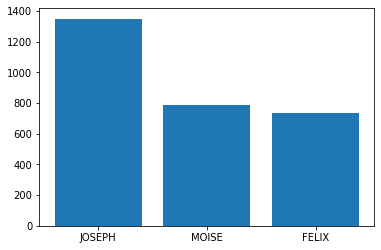

In [105]:
plt.bar(train_data['labels'].value_counts().index, train_data['labels'].value_counts().values)
plt.show()

### Visualisons certaines de nos images et voyons à quoi elles ressemblent  réellement.

In [106]:
def plot(image_batch, label_batch):
    plt.figure(figsize=(10,5))
    
    for i in range(10) :
        ax  = plt.subplot(2,5,i+1)
        
        try:
            img = cv2.imread(str(image_batch[i]))
            img = cv2.resize(img,(224,224))
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title(label_batch[i])
            plt.axis("off")
        
        except Exception as e:
            print(str(e))

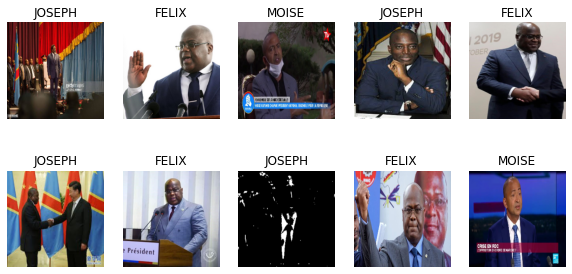

In [107]:
plot(train_data['images'], train_data['labels'])

# ETAPE II : Prétraitement des données

### Les différentes étapes de prétraitement que nous allons utiliser ici sont les suivantes :

1) Puisque les images sont de différentes longueurs et largeurs, nous allons les redimensionnez  à 224,224,3.

2) Certaines images sont en gris (1 canal), nous allons donc les convertir en 3 canaux.

3) Les images lues avec cv2 sont au format BGR (par défaut), nous allons les convertir en RGB.

4) Ensuite nous allons proceder par la division des  pixels de l'image par 255 (une astuce mathématique essentielle pour de meilleures performances)

In [11]:
def pre_preparation(v = True) :
    if v == True :
        dir_moise = val_dir/'moise'
        dir_felix = val_dir/'felix'
        dir_joseph = val_dir/'joseph'
    else:
        dir_moise = test_dir/'moise'
        dir_felix = test_dir/'felix'
        dir_joseph = test_dir/'joseph'
        
    moises = dir_moise.glob('*.jpg')
    felix = dir_felix.glob('*.jpg')
    joseph = dir_joseph.glob('*.jpg')

    data , labels = ([] for x in range (2))

    def prepare(case):  
        for img in case:
            img = cv2.imread(str(img))
            img = cv2.resize(img,(224,224))
            
            if img.shape[2] == 1 :
                img  = np.dstack([img,img,img])
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255
            
            if case == felix:
                label = to_categorical(0,num_classes = 3)
            elif case == joseph:
                label = to_categorical(1, num_classes=3)
            
            elif case == moises:
                label = to_categorical(2, num_classes=3)
            
            data.append(img)
            labels.append(label)
        return data, labels
    
    prepare(moises)
    prepare(joseph)
    d,l = prepare(felix)
    d = np.array(d)
    l=np.array(l)
    return d,l


In [12]:
val_data, val_label = pre_preparation(v=True)
test_data, test_labels = pre_preparation(v=False)

print('Nombre des images de test --->> ',len(test_data))
print("Nombre des images de validation --->>", len(val_data))

Nombre des images de test --->>  721
Nombre des images de validation --->> 30


### Nous allons maintenant écrire une fonction pour générer des images par lots à partir des données d'entrainement.

In [79]:
def data_gen(data, batch_size):
    n = len(data)
    
    steps = n//batch_size
    
    
    batch_data = np.zeros((batch_size, 224,224, 3), dtype = np.float32)
    batch_labels = np.zeros((batch_size,3), dtype = np.float32)
    
    indices = np.arange(n)
    
    i = 0
    
    while True :
        np.random.shuffle(indices)
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch) :
            img_name  = data.iloc[idx]['images']
            label = data.iloc[idx]['labels']
            
            if label == 'FELIX' :
                label = 0
            elif label == 'JOSEPH' :
                label = 1
            elif label == 'MOISE' :
                label = 2;
            
            
            encoded_label = to_categorical(label, num_classes = 3)
            img = cv2.imread(str(img_name))
            img = cv2.resize(img,(224,224))
            
            if(img.shape[2] == 1) :
                img = np.dstack([img,img,img])
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            orig_img = img.astype(np.float32) / 255
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            count += 1
            
            if count == batch_size -1:
                break
        i+=1
        yield batch_data, batch_labels
        
        if i>= steps :
            i=0

# ETAPE 4 : Construire une image CNN

### Modèle Python de classification à partir de zéro

In [80]:
model = Sequential()

In [81]:
model.add(Conv2D(32,(3,3), input_shape = (224,224,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

In [82]:
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

In [83]:
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

In [84]:
model.add(Flatten())

In [85]:
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(3))
model.add(Activation('softmax'))

In [86]:
batch_size = 20
nb_epochs = 6

train_data_gen = data_gen(data= train_data, batch_size = batch_size)

In [87]:
nb_train_steps = train_data.shape[0]//batch_size

'batch_size' fait référence au nombre d'images fournies au réseau en un seul passage

In [118]:
print("Nombre d'etape d'entrainement et de validation des données {} et {}".format(nb_train_steps, len(val_data)))

Nombre d'etape d'entrainement et de validation des données 143 et 30


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

On va utiliser la une fonction callback appelée EarlyStopping pour arrêter l'entraînement lorsque la val_loss baisse s'arrête.

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]



Lancement de l'entrainement de notre modèle 

In [ ]:
history = model.fit(train_data_gen,   epochs = nb_epochs,
                    steps_per_epoch  = nb_train_steps,
                    validation_data = (val_data , val_label),
                    callbacks=my_callbacks
                   )

## Interpretation des resultats de notre modèle 

Il est tout à fait évident que la précision de notre validation n'est pas si bonne.

val_accurancy = 0.65 mais avec une perte enorme de 4.75

Il existe un certain nombre d'astuces que nous pouvons utiliser pour obtenir de bonnes performances. Entre autre : 

* Modifier la taille du lot. (chercher la bonne taille)
* Réajuster le nombre d'epoque pendant l'entrainement.
* Chercher un autre optimiseur. 
* Modifier le réseau neuronal en ajoutant/supprimant des couches.
* Augmenter la taille de notre Dataset

Apres plusieurs  essais (de la 1ere à la 3eme) techniques sans trouver un bon resultat, nous avons opté pour une autre alternative, l'utilisation de l'apprentissage par transfert

# ETAPE IV  : Apprentissage par transfert

L'apprentissage par transfert est une technique qui consiste à utiliser des réseaux neuronaux pré-formés sur des milliards d'images (comme Alexnet, Inception net, VGG16) pour une tâche différente en modifiant la dernière couche de classification.

Pour notre cas, nous allons utiliser le VGG16 pré-entraîné et nous ajouterons notre propre couche de classification (Dense) en bas, puis nous figerons le réseau jusqu'à l'avant-dernier bloc convolutif, puis nous le réentraînerons.

In [ ]:
def vgg16_model(num_classes = None):
    model = VGG16(weights='imagenet', include_top = True, input_shape=(224,224,3))
    x = Dense(1024, activation ='relu')(model.layers[-4].output)
    x = Dropout(0.7)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(2,activation = 'softmax')(x)
    model=Model(model.input, x)
    
    return model


In [ ]:
vgg_conv = vgg16_model(3)

for layer in vgg_conv.layers[:-10]:
    layer.trainable =  False
opt = Adam(learning_rate=0.0001, decay = 1e-5)
vgg_conv.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)

Lancement de l'entrainement du modèle optenu par transfert

In [69]:
history = vgg_conv.fit(train_data_gen,   epochs = nb_epochs,
                    steps_per_epoch  = nb_train_steps,
                    validation_data = (val_data , val_label),
                    callbacks=my_callbacks,
                    class_weight={0:1.0,1:0.4}
                   )

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20
84/84 [==============================] - 838s 10s/step - loss: 0.3538 - accuracy: 0.7071 - val_loss: 0.1027 - val_accuracy: 1.0000
Epoch 2/20
84/84 [==============================] - 806s 10s/step - loss: 0.1372 - accuracy: 0.9095 - val_loss: 0.1406 - val_accuracy: 0.9500
Epoch 3/20
84/84 [==============================] - 783s 9s/step - loss: 0.0683 - accuracy: 0.9565 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 4/20
84/84 [==============================] - 787s 9s/step - loss: 0.0312 - accuracy: 0.9810 - val_loss: 2.0561e-04 - val_accuracy: 1.0000
Epoch 5/20
84/84 [==============================] - 794s 9s/step - loss: 0.0450 - accuracy: 0.9756 - val_loss: 0.0123 - val_accuracy: 1.0000
Epoch 6/20
84/84 [==============================] - 803s 10s/step - loss: 0.0180 - accuracy: 0.9911 - val_loss: 0.0265 - val_accuracy: 1.0000


In [74]:
perte, precision  = vgg_conv.evaluate(test_data, test_labels, batch_size = 20)
print("Perte : {} et precision : {} ".format(perte, precision))

20/20 [==============================] - 151s 8s/step - loss: 0.4795 - accuracy: 0.8857
Perte : 0.4795375168323517 et precision : 0.8857142925262451 


 # ETAPE V  :  Évaluation des performances du modèle de classification des images

Jetons un coup d'œil au rapport de classification

In [76]:
pred = vgg_conv.predict(test_data, batch_size=20)
pred = np.argmax(pred, axis = -1)

In [78]:
labels = np.argmax(test_labels, axis = -1)

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90       224
           1       0.81      0.95      0.87       161

    accuracy                           0.89       385
   macro avg       0.88      0.89      0.88       385
weighted avg       0.90      0.89      0.89       385



<AxesSubplot:>

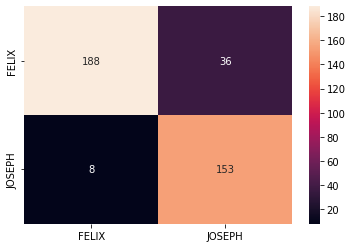

In [82]:
cm  = confusion_matrix(labels, pred)
sns.heatmap(cm, annot=True, fmt='g', xticklabels =['FELIX','JOSEPH'], yticklabels = ['FELIX','JOSEPH'])